# Resources used to build this script

https://earth-env-data-science.github.io/lectures/xarray/xarray-part2.html

erddap_xarray.ipynb from the NOAA hackour 2025 folder

This was the original one I used but it no longer works: https://comet.nefsc.noaa.gov/erddap/griddap/noaa_psl_2d74_d418_a6fb.html

As of 4/16/25 I am using https://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst21Agg.html, however this ERDDAP server went down.

At this page, scroll to the Data Access section: https://www.ncei.noaa.gov/products/climate-data-records/sea-surface-temperature-optimum-interpolation

https://www.ncei.noaa.gov/products/climate-data-records/sea-surface-temperature-optimum-interpolation

# Here's what we are going to do

Q: how are animals figuring out to go up north

A: make monthly map of SST from GoG to Dakar

Produce a PDF and send it around - CVI to Dakar and down to GoG

With this info we will think about the right boxes to make - qualitative examination

Pick regions and perhaps groups of months

Compute temp anaomalies and absolute temperatures as a timeseries in each region, as well as the spatial

Perhaps compute difference between two regions, e.g. GoG vs CVI

### For solving the prime meridian problem - consider converting to UTM

UTM zones are every 10 degrees, so we may need more than one zone.

### Add notes here for things that should be in the paper
-Methods?
-Results?
-Discussion?


# Clear memory

In [63]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


## Look at variables in memory

In [64]:
whos

Interactive namespace is empty.


# Import packages

In [65]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

# Read metadata from NOAA OISST v2.1 from ERDDAP

In [66]:
#url = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/ncdcOisst21Agg'
#url = 'https://www.ncei.noaa.gov/erddap/griddap/ncdc_oisst_v2_avhrr_by_time_zlev_lat_lon'
#url = 'https://155.206.139.160/erddap/griddap/noaa_psl_2d74_d418_a6fb'
#url = "https://coastwatch.pfeg.noaa.gov/erddap/griddap/jplMURSST41"
url = 'https://comet.nefsc.noaa.gov/erddap/griddap/noaa_psl_2d74_d418_a6fb' # Sea Surface Tempearture, NOAA/NCEI Optimum Interpolation SST (OISST) AVHRR-only Analysis (V2.1), Global 0.25°, Monthly 1981-present
ds = xr.open_dataset(url)
print(f"Size in GB: {ds.nbytes / 1e9:.2f} GB")
ds.sizes
ds

Size in GB: 2.17 GB


<xarray.Dataset> Size: 2GB
Dimensions:    (time: 523, latitude: 720, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2025-03-01
  * latitude   (latitude) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * longitude  (longitude) float32 6kB 0.125 0.375 0.625 ... 359.4 359.6 359.9
Data variables:
    sst        (time, latitude, longitude) float32 2GB ...
Attributes: (12/35)
    cdm_data_type:              Grid
    comment:                    Reynolds, et al.(2007) Daily High-Resolution-...
    Conventions:                CF-1.10, COARDS, ACDD-1.3
    creator_name:               NOAA/National Centers for Environmental Infor...
    creator_type:               group
    creator_url:                https://www.noaa.gov/
    ...                         ...
    testOutOfDate:              now-114days
    time_coverage_end:          2025-03-01T00:00:00Z
    time_coverage_start:        1981-09-01T00:00:00Z
    title:                      Sea Surface Tempearture, NOAA/NCEI Optimum In...
    version:                    Version 2.1
    Westernmost_Easting:        0.125

In [67]:
# rename ds
ds1 = ds

# Change longitudes to -180 to +180 so that you can plot across the prime meridian

See https://docs.xarray.dev/en/stable/generated/xarray.Dataset.assign_coords.html

# Confirm that lognitudes have been reset to -180 to +180

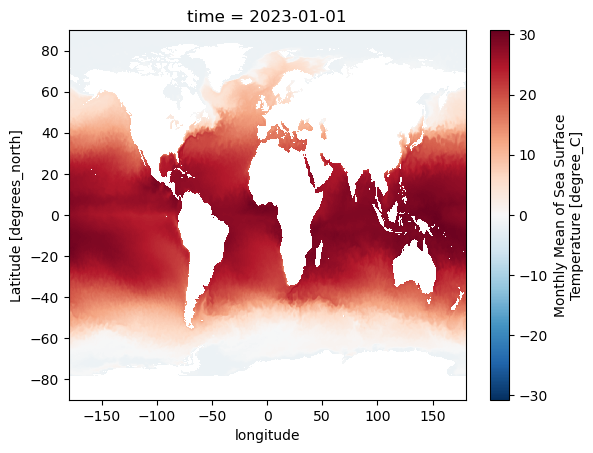

In [68]:
ds2 = ds1.assign_coords(longitude = ((ds1.longitude + 180) % 360) - 180)
ds2 = ds2.sortby('longitude') # don't forget to sort!!
ds2['sst'].sel(time = "2023-01").plot()

# Set some boundaries and locations

In [69]:
colormap = 'RdBu_r'

date_range = ("1982-01-01", "2024-12-01")

lat_min = -10
lat_max = 20
lon_min = -30
lon_max = 15

#create smaller box for the local region
lat_min_sm = 12.6
lat_max_sm = 16.6
lon_min_sm = -19.6
lon_max_sm = -15.6

#input deployment locations
#site 1 deployment 1
deployment0101_lat = 14.616
deployment0101_lon = -17.631

#site 1, deployment 2
deployment0102_lat =14.615
deployment0102_lon =-17.630

#site 1, deployment 3
deployment0103_lat = 14.618
deployment0103_lon = -17.628

#site 1, deployment 4
deployment0104_lat = 14.618
deployment0104_lon = -17.628

#site 2, deployments 1 & 2
deployment020102_lat = 14.742
deployment020102_lon = -17.636

#region around recorders
rec_lat_min = 12 
rec_lat_max = 17
rec_lon_min = -12
rec_lon_max = -20

#CVI coords
CVI_lat_min = 14
CVI_lat_max = 18
CVI_lon_min = -27
CVI_lon_max = -21

#GoG Gulf of Guinea
GoG_lat_min = -10
GoG_lat_max = 7
GoG_lon_min = 6
GoG_lon_max = 15

## Create spatial subset dataset and visualize it

In [70]:
dsBigBox = ds2['sst'].sel(latitude=slice(lat_min, lat_max), 
                longitude=slice(lon_min, lon_max))
dsBigBox

<xarray.DataArray 'sst' (time: 523, latitude: 120, longitude: 180)> Size: 45MB
[11296800 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2025-03-01
  * latitude   (latitude) float32 480B -9.875 -9.625 -9.375 ... 19.62 19.88
  * longitude  (longitude) float32 720B -29.88 -29.62 -29.38 ... 14.62 14.88
Attributes: (12/13)
    actual_range:     [-1.8  32.14]
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    level_desc:       Surface
    long_name:        Monthly Mean of Sea Surface Temperature
    ...               ...
    precision:        2.0
    standard_name:    sea_surface_temperature
    statistic:        Monthly Mean
    units:            degree_C
    valid_range:      [-3. 45.]
    var_desc:         Sea Surface Temperature

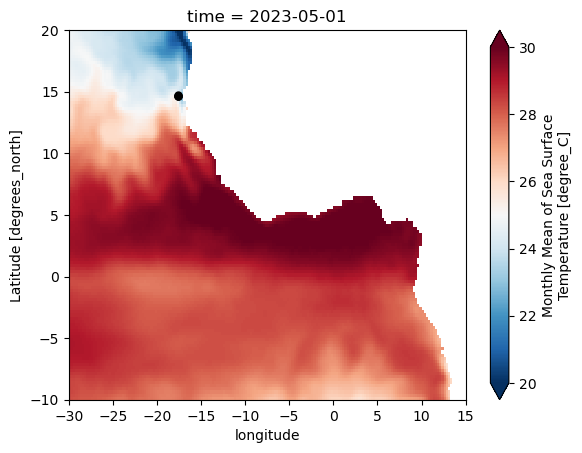

In [71]:
fig, ax = plt.subplots()
dsBigBox.sel(time = "2023-05").plot(cmap = colormap, vmin = 20, vmax = 30)
ax.plot(deployment0101_lon, deployment0101_lat, marker='o', color='k', markersize=5)
ax.plot(deployment0102_lon, deployment0102_lat, marker='o', color='k', markersize=5)
ax.plot(deployment0103_lon, deployment0103_lat, marker='o', color='k', markersize=5)
ax.plot(deployment020102_lon, deployment020102_lat, marker='o', color='k', markersize=5)

# Compute monthly climatology and plot each month

In [72]:
clim_spat = dsBigBox.groupby("time.month").mean("time")
clim_spat

KeyboardInterrupt: 

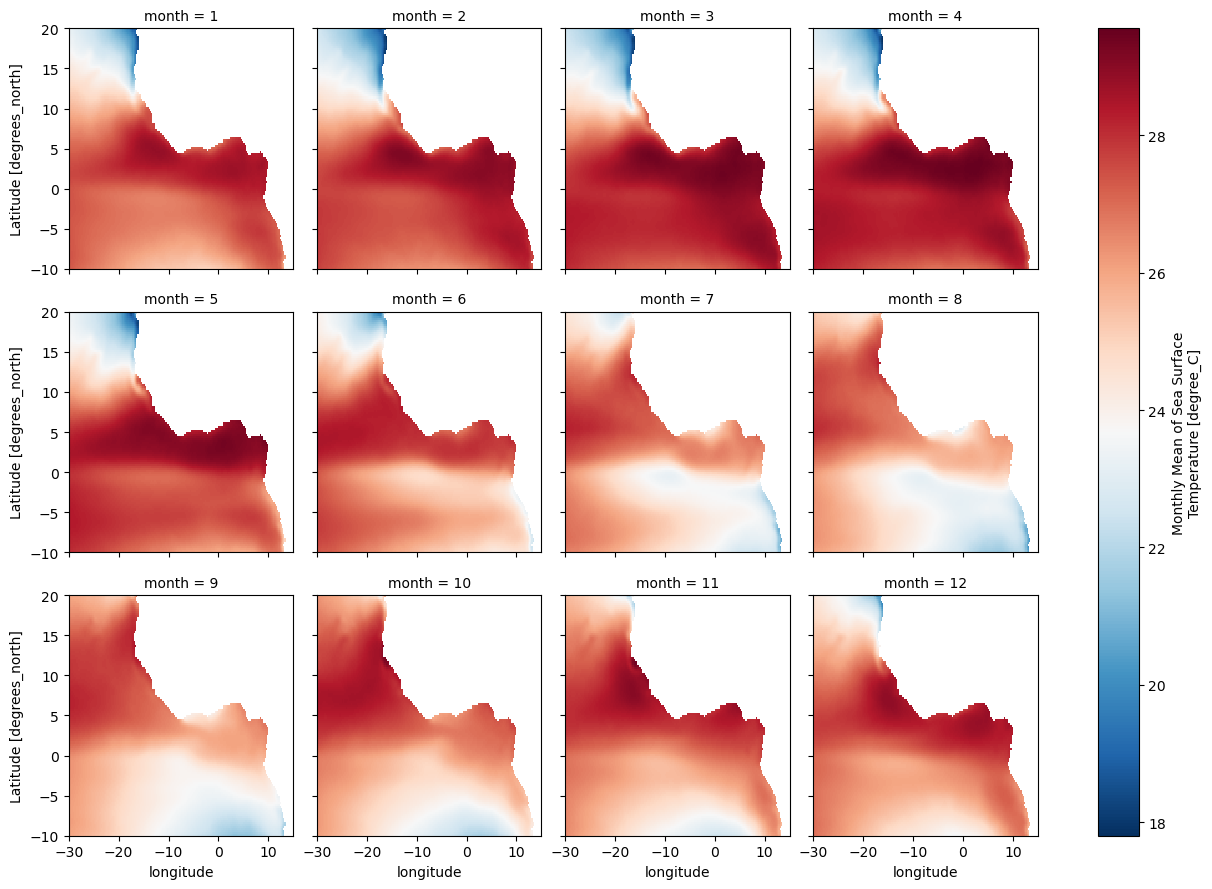

In [30]:
clim_spat.plot(x='longitude', y='latitude', col="month", col_wrap=4, cmap = colormap);

In [31]:
anom_spat = dsBigBox.groupby("time.month") - clim_spat
anom_spat

<xarray.DataArray 'sst' (time: 523, latitude: 120, longitude: 180)> Size: 45MB
array([[[-0.43810654, -0.39212227, -0.3357792 , ...,         nan,
                 nan,         nan],
        [-0.4317646 , -0.41552162, -0.38536263, ...,         nan,
                 nan,         nan],
        [-0.41160583, -0.41727257, -0.3964615 , ...,         nan,
                 nan,         nan],
        ...,
        [-0.44764328, -0.4254322 , -0.36349106, ...,         nan,
                 nan,         nan],
        [-0.48346138, -0.47393227, -0.42817497, ...,         nan,
                 nan,         nan],
        [-0.4354782 , -0.45223427, -0.4358406 , ...,         nan,
                 nan,         nan]],

       [[-0.25844574, -0.27214813, -0.27841568, ...,         nan,
                 nan,         nan],
        [-0.29877472, -0.28712463, -0.25958252, ...,         nan,
                 nan,         nan],
        [-0.3101158 , -0.2885933 , -0.24409103, ...,         nan,
                 nan,         nan],
...
        [ 0.4930992 ,  0.49910355,  0.5057106 , ...,         nan,
                 nan,         nan],
        [ 0.5619526 ,  0.5742607 ,  0.56541634, ...,         nan,
                 nan,         nan],
        [ 0.68224907,  0.70168686,  0.6651325 , ...,         nan,
                 nan,         nan]],

       [[ 0.1283226 ,  0.10304832,  0.06536674, ...,         nan,
                 nan,         nan],
        [ 0.11511612,  0.09302139,  0.0642662 , ...,         nan,
                 nan,         nan],
        [ 0.10131264,  0.08381271,  0.06530762, ...,         nan,
                 nan,         nan],
        ...,
        [ 0.3277855 ,  0.36762428,  0.40375328, ...,         nan,
                 nan,         nan],
        [ 0.4171543 ,  0.46328354,  0.51789665, ...,         nan,
                 nan,         nan],
        [ 0.5091286 ,  0.5549202 ,  0.61222076, ...,         nan,
                 nan,         nan]]], shape=(523, 120, 180), dtype=float32)
Coordinates:
  * time       (time) datetime64[ns] 4kB 1981-09-01 1981-10-01 ... 2025-03-01
  * latitude   (latitude) float32 480B -9.875 -9.625 -9.375 ... 19.62 19.88
  * longitude  (longitude) float32 720B -29.88 -29.62 -29.38 ... 14.62 14.88
    month      (time) int64 4kB 9 10 11 12 1 2 3 4 5 6 ... 7 8 9 10 11 12 1 2 3

In [46]:
yrs = (["2015-01-01","2015-12-01"],
      ["2016-01-01","2016-12-01"],
      ["2017-01-01","2017-12-01"],
      ["2018-01-01","2018-12-01"],
      ["2019-01-01","2019-12-01"],
      ["2020-01-01","2020-12-01"],
      ["2021-01-01","2021-12-01"],
      ["2022-01-01","2022-12-01"],
      ["2023-01-01","2023-12-01"],
      ["2024-01-01","2024-12-01"])

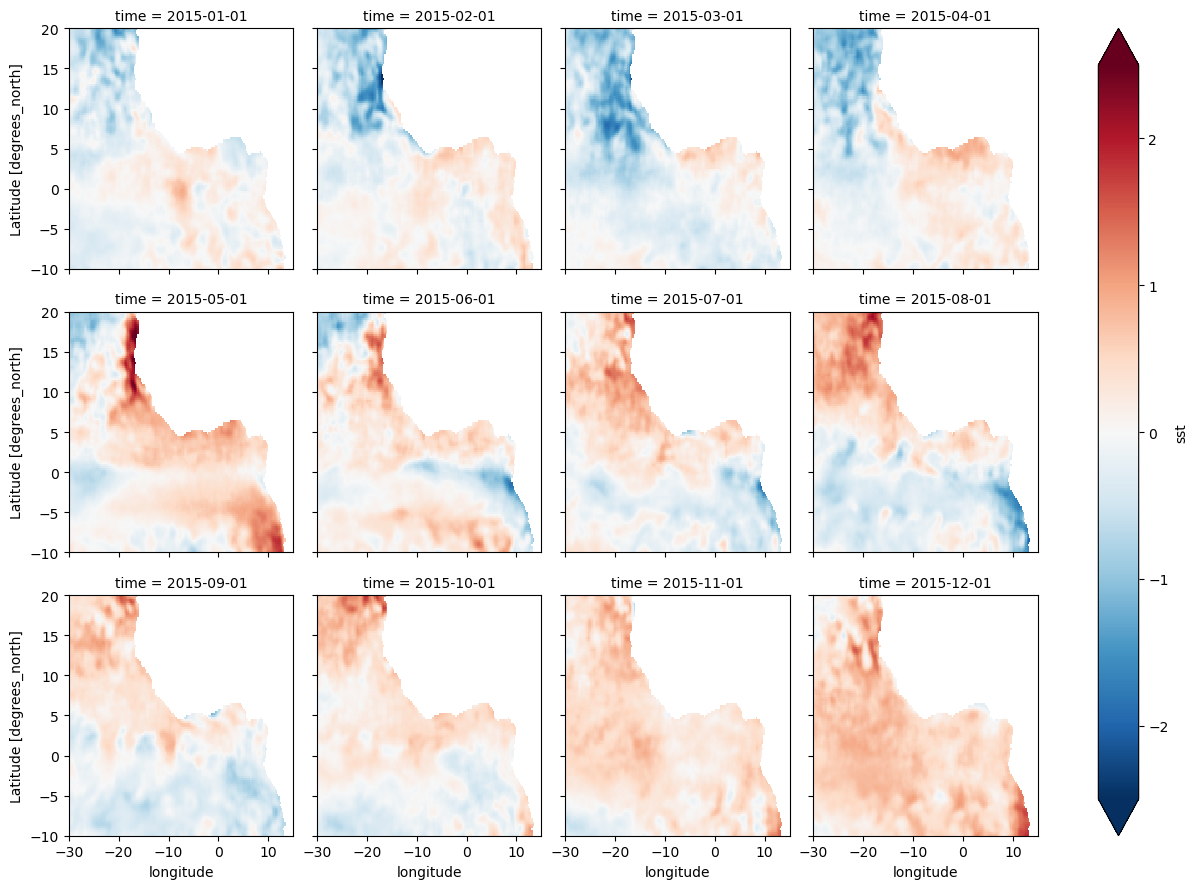

In [41]:
anom_spat.sel(time = slice(yrs[0][0],yrs[0][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

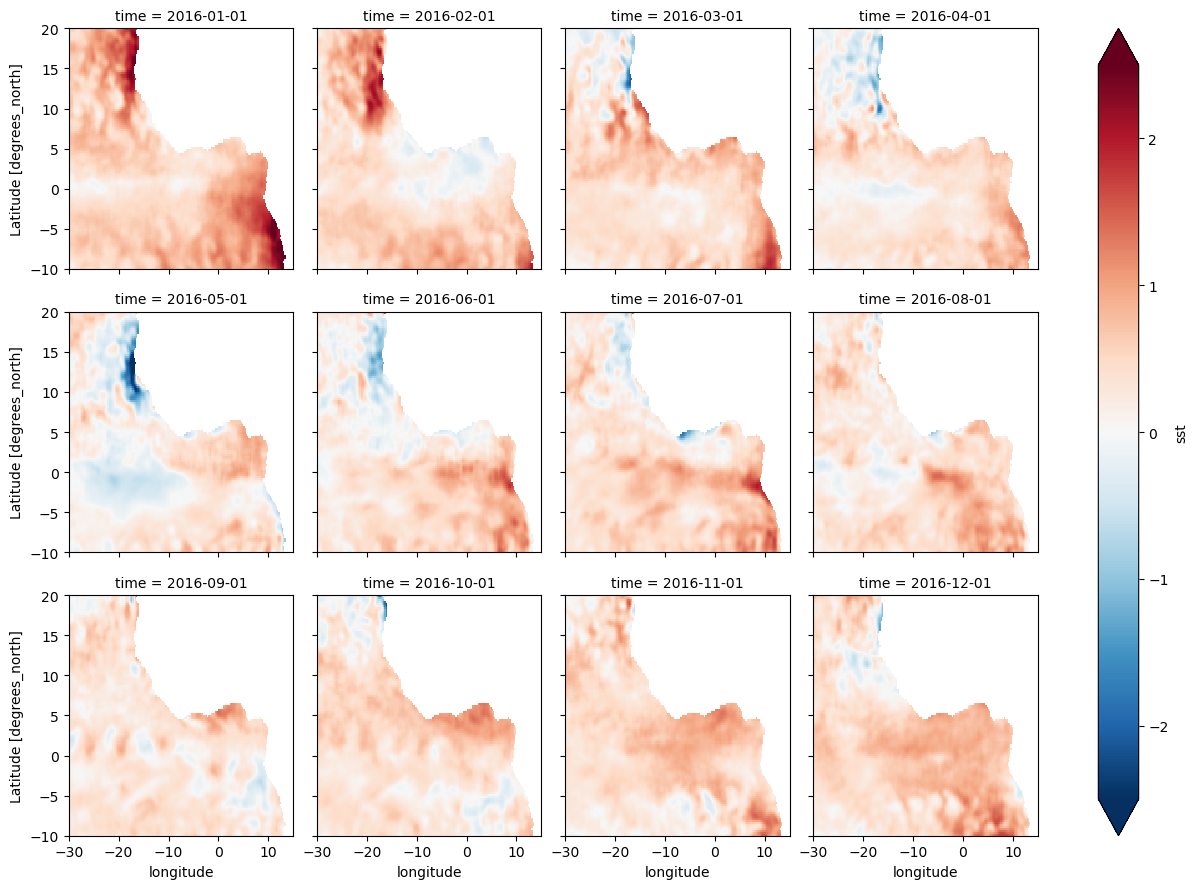

In [42]:
anom_spat.sel(time = slice(yrs[1][0],yrs[1][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

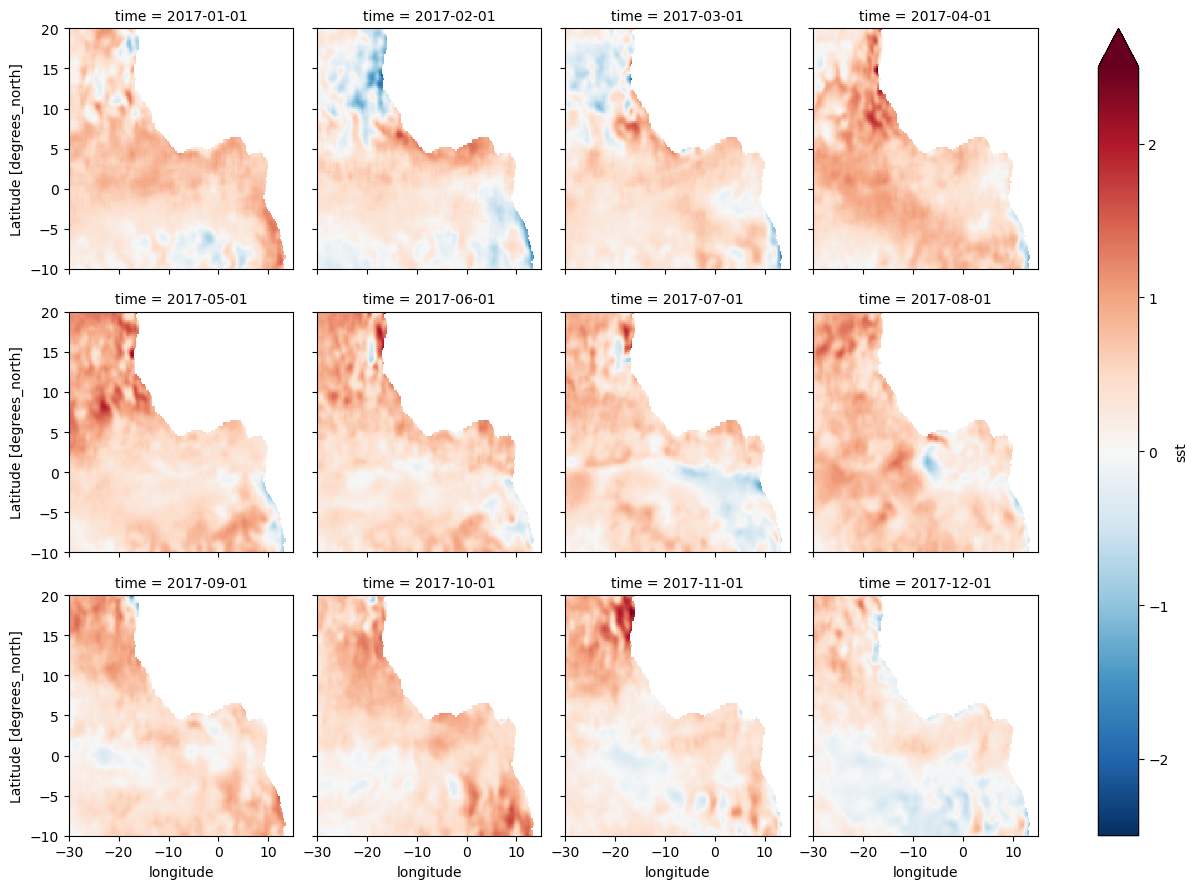

In [48]:
anom_spat.sel(time = slice(yrs[2][0],yrs[2][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

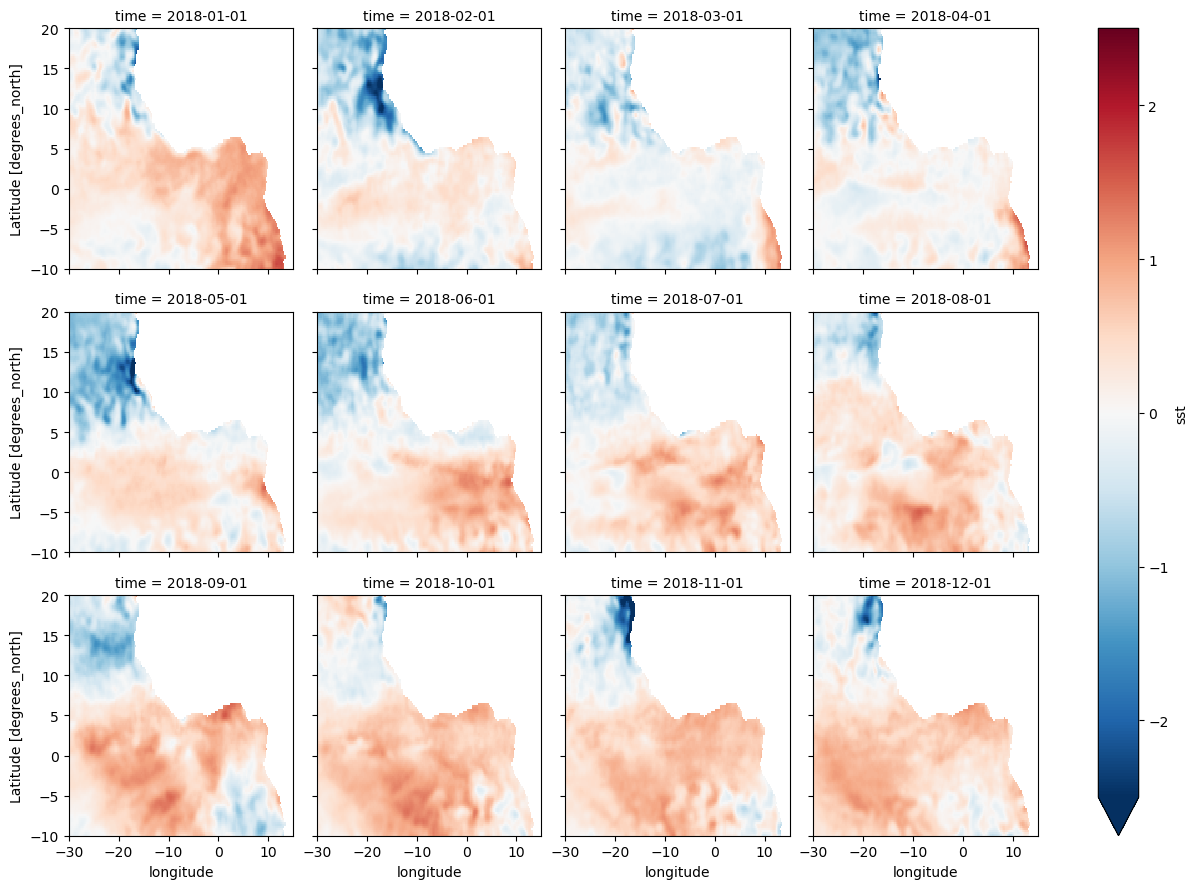

In [49]:
anom_spat.sel(time = slice(yrs[3][0],yrs[3][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

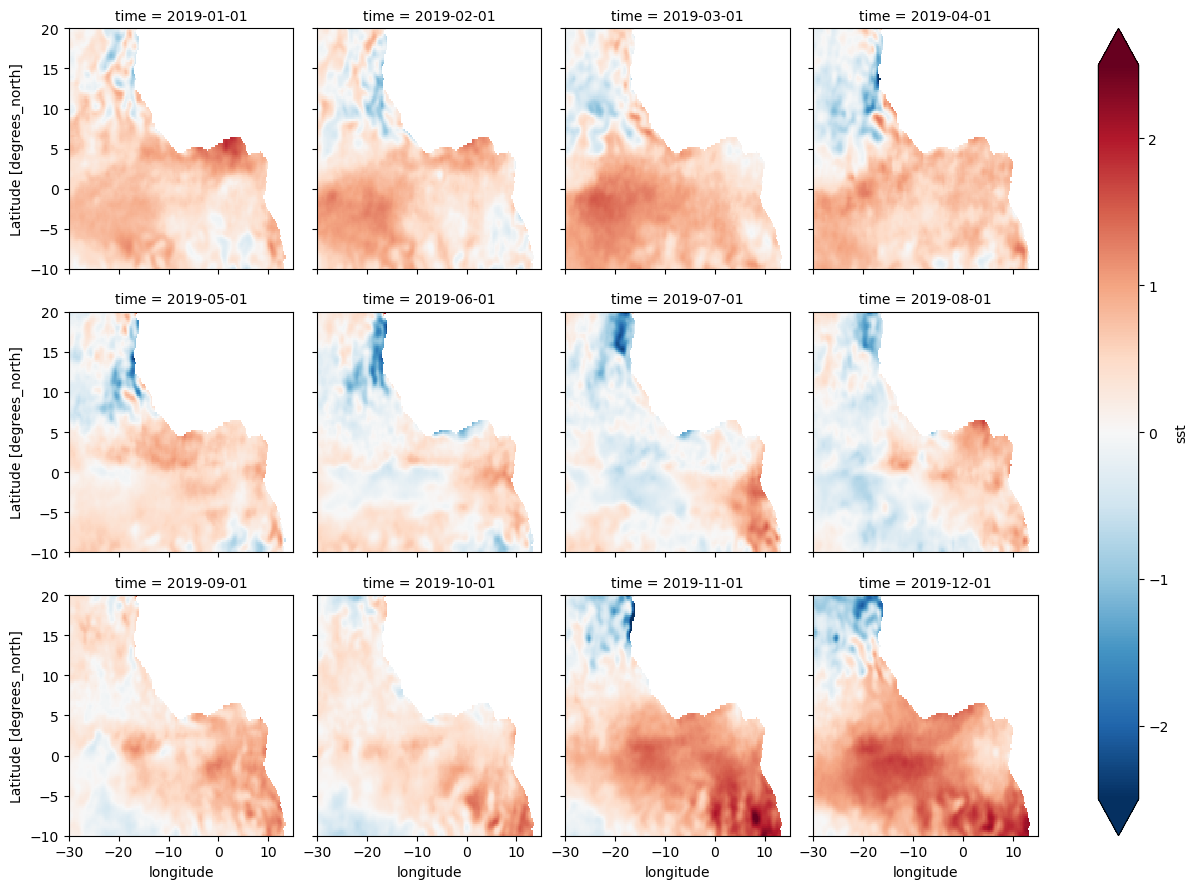

In [50]:
anom_spat.sel(time = slice(yrs[4][0],yrs[4][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

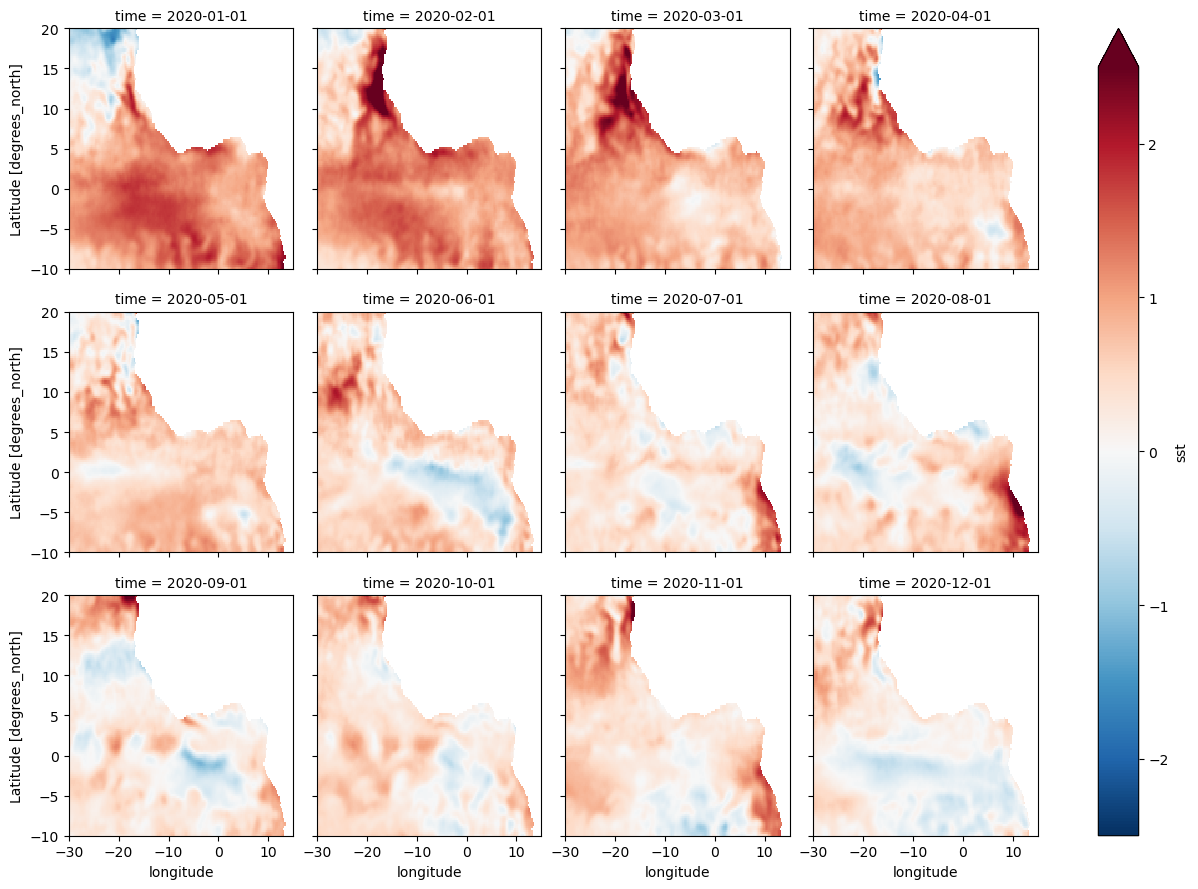

In [51]:
anom_spat.sel(time = slice(yrs[5][0],yrs[5][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

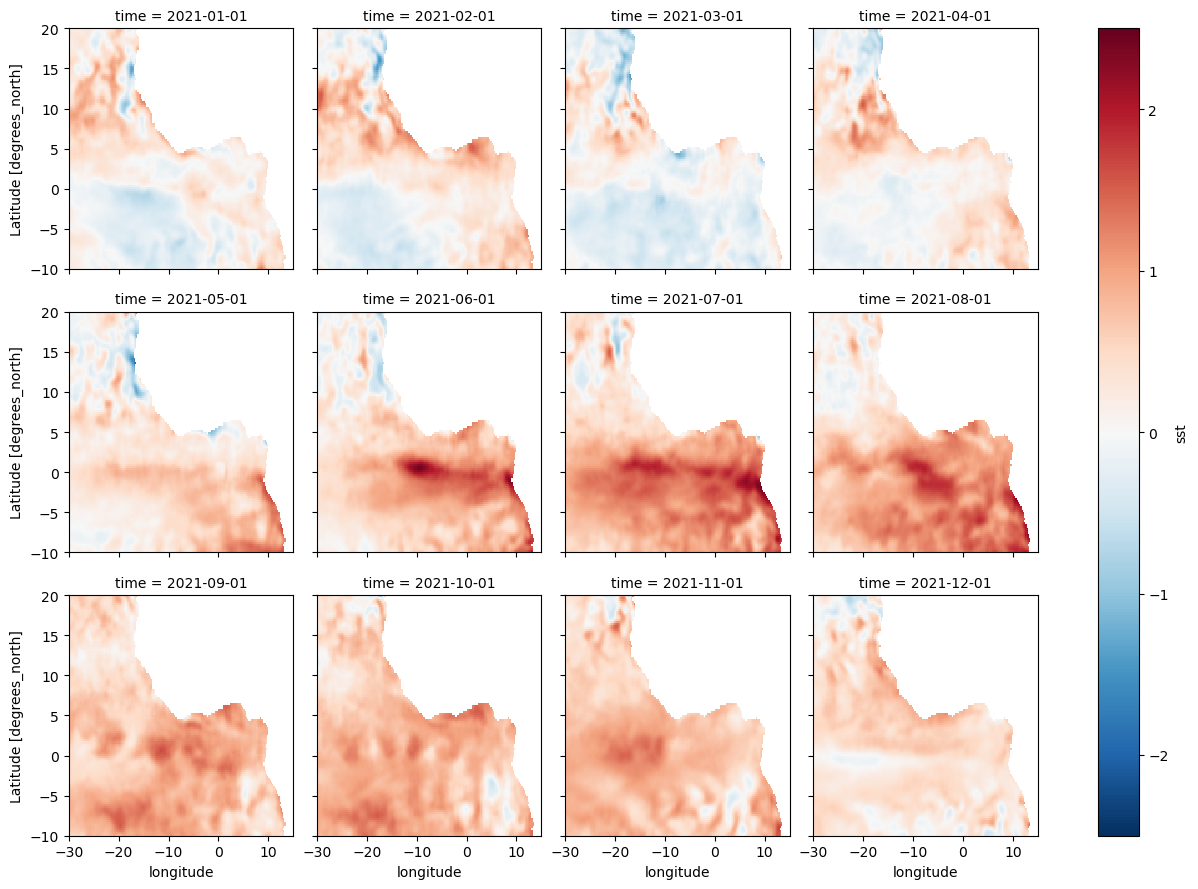

In [52]:
anom_spat.sel(time = slice(yrs[6][0],yrs[6][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

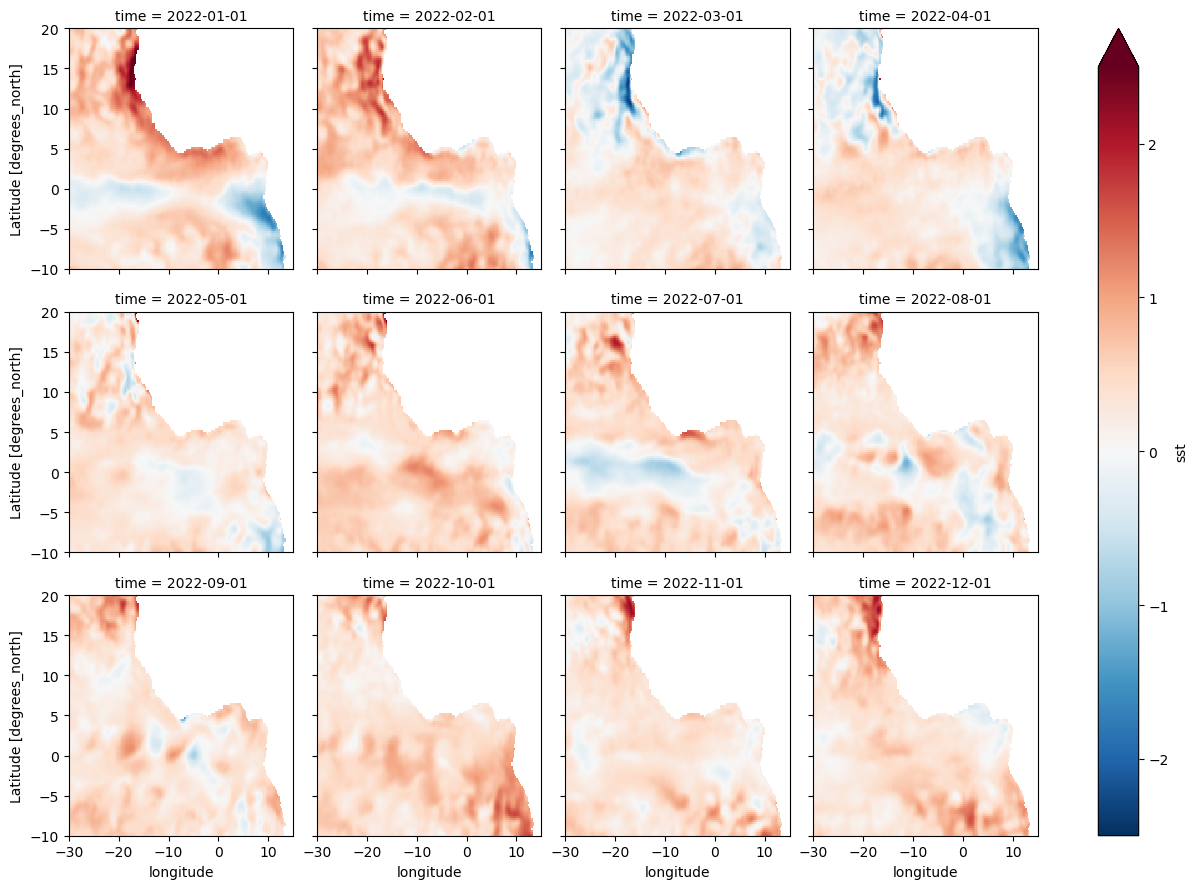

In [53]:
anom_spat.sel(time = slice(yrs[7][0],yrs[7][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

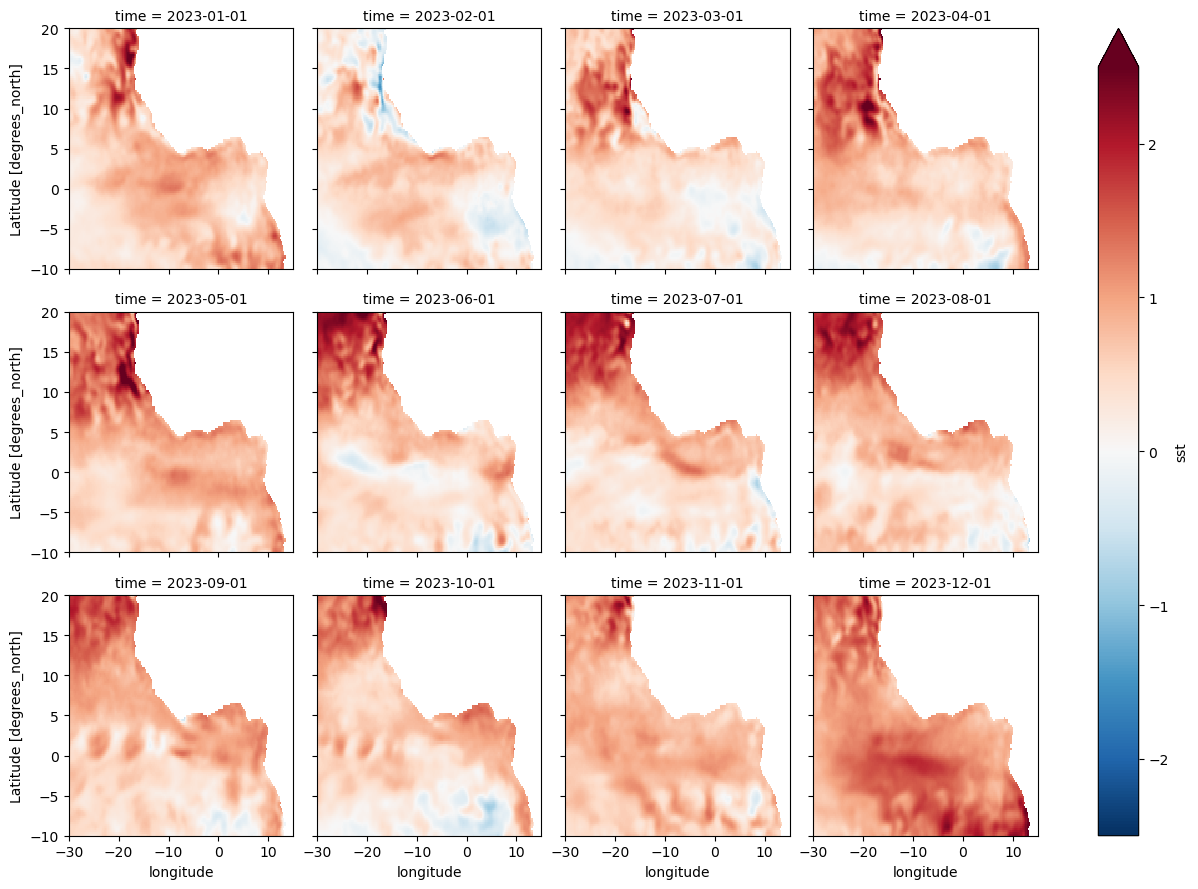

In [54]:
anom_spat.sel(time = slice(yrs[8][0],yrs[8][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

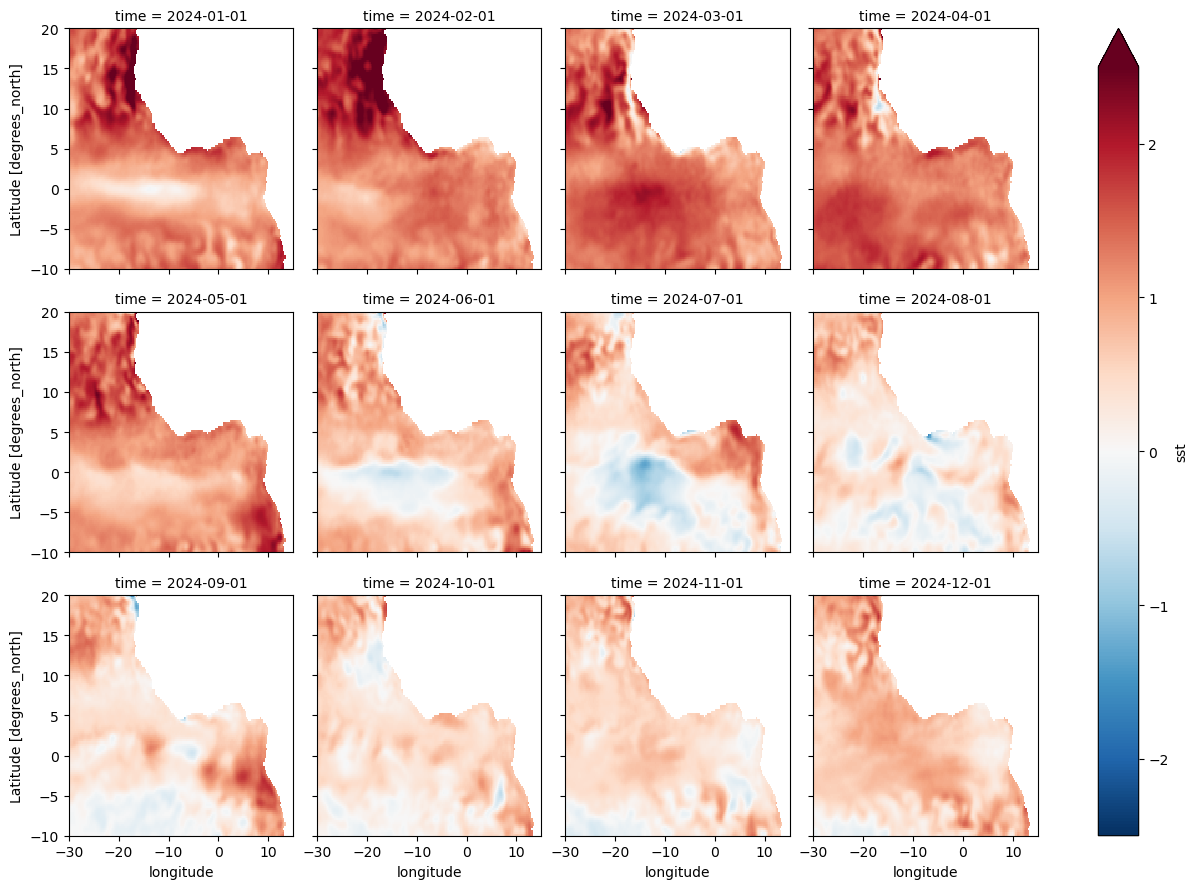

In [55]:
anom_spat.sel(time = slice(yrs[9][0],yrs[9][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4, cmap = colormap, vmin = -2.5, vmax = 2.5)

In [62]:
dsBigBox.sel(time = slice(yrs[0][0],yrs[0][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4)

KeyboardInterrupt: 

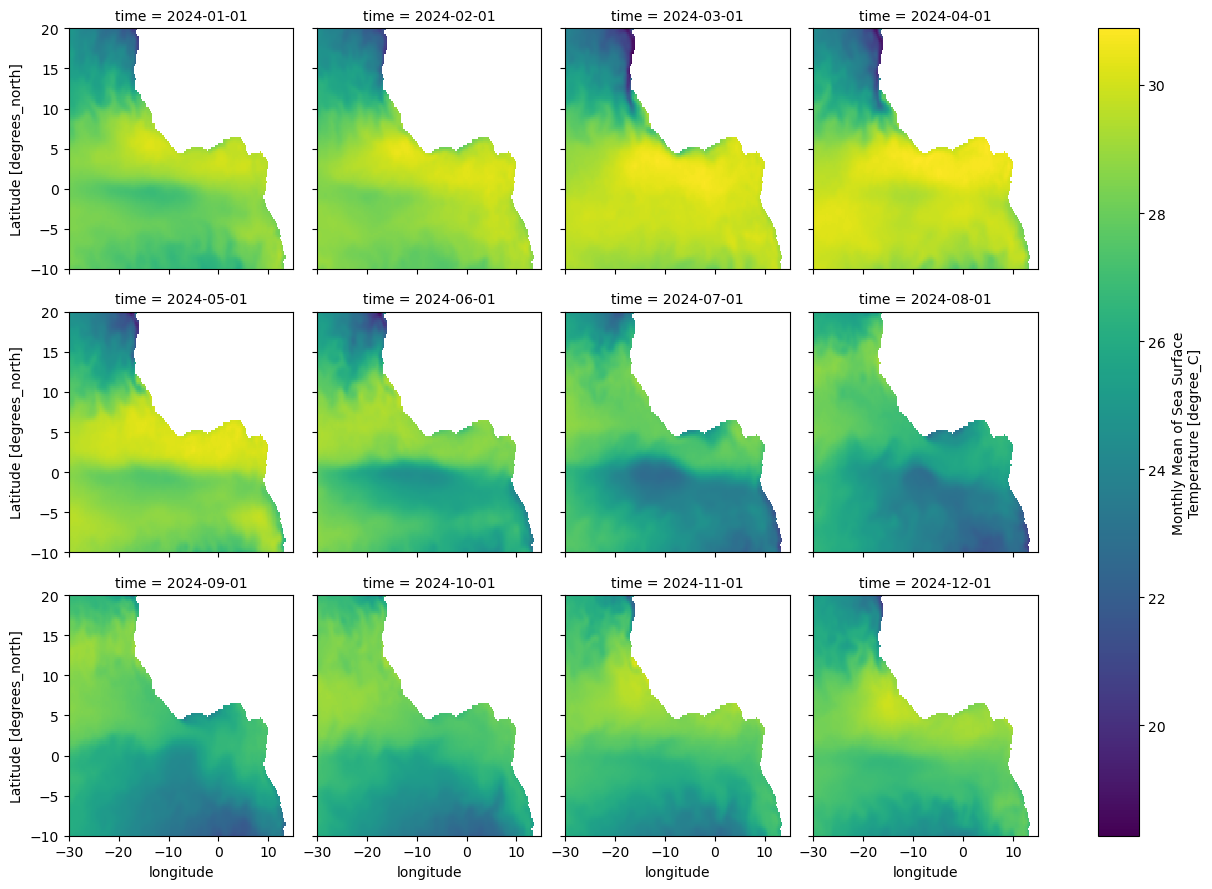

In [60]:
dsBigBox.sel(time = slice(yrs[9][0],yrs[9][1])).plot(x = "longitude", y = "latitude", col = "time", col_wrap=4)

# Create monthly climatology and monthly anomalies
### climatology will have one layer for each month
### anomalies will be the difference between climatology and every month in dc

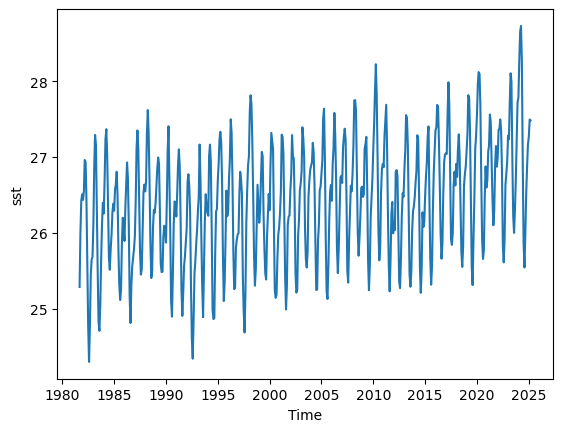

In [37]:
#average over all space against time (monthly means over the domain)
dsBigBox.mean(dim=['latitude', 'longitude']).plot();

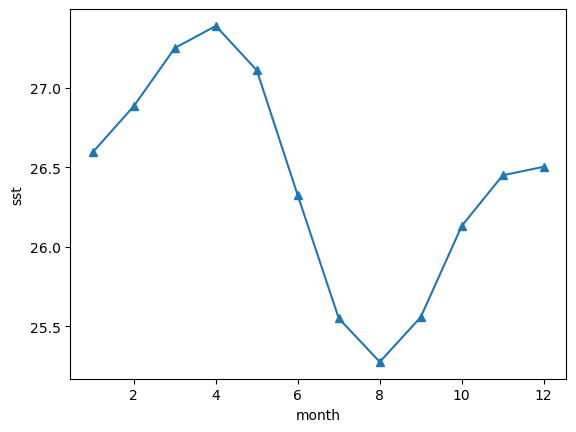

In [38]:
# plot monthly climatology. Note how different this looks due to including southern hemisphere
clim_spat.mean(dim = ['latitude','longitude']).plot(marker = "^")

In [61]:
# calculate monthly anomaly means over space, and zero-line to show the mean
month_anom_means = anom_spat.mean(dim = ['latitude','longitude'])
zero_line = month_anom_means*0

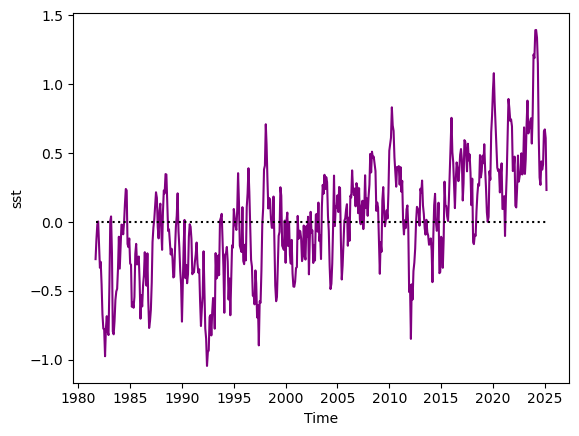

In [62]:
# plot full timeseries of monthly anomalies
fig, ax = plt.subplots()
month_anom_means.plot(color="purple")
zero_line.plot(linestyle = ':', color = "k" )

# Plots monthly means over space, and climatology

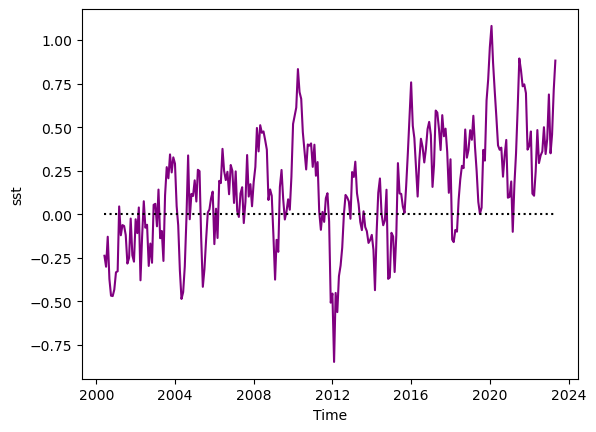

In [93]:
# plot sst anomalies just for the period of time when recorders were deployed
t1 = '2000-06-01'; t2 = '2023-05-01'

fig, ax = plt.subplots()
month_anom_means.sel(time = slice (t1, t2)).plot(color = "purple")
zero_line.sel(time = slice(t1,t2)).plot(color = "black", linestyle = ":")

# Plot the anomaly as a time series 

## Plot continuous subset of the timeseries

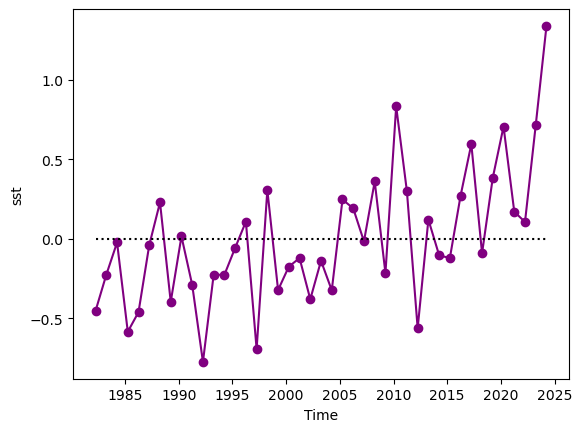

In [90]:
#plot all temps for month = m
m = 4
month_anom_means_m = month_anom_means.sel(time = (month_anom_means.time.dt.month == m))

t1 = '2015-06-01'; t2 = '2023-05-01'
ts = dc_anom.sel(time=slice(t1, t2)).mean(dim = ['latitude','longitude'])


fig, ax = plt.subplots()
month_anom_means_m.plot(color="purple", marker="o")
zero_line.sel(time = zero_line.time.dt.month == m).plot(color = "black", linestyle = ":")

## Plot mean temperature anomalies for a particular month

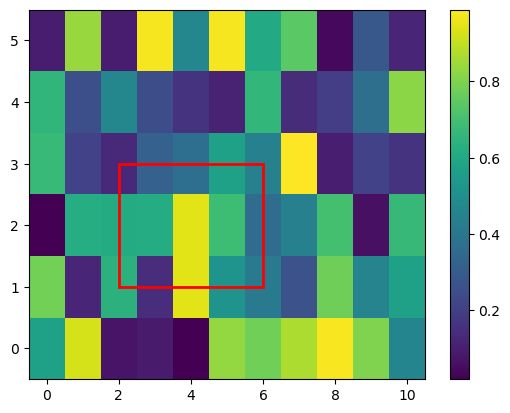

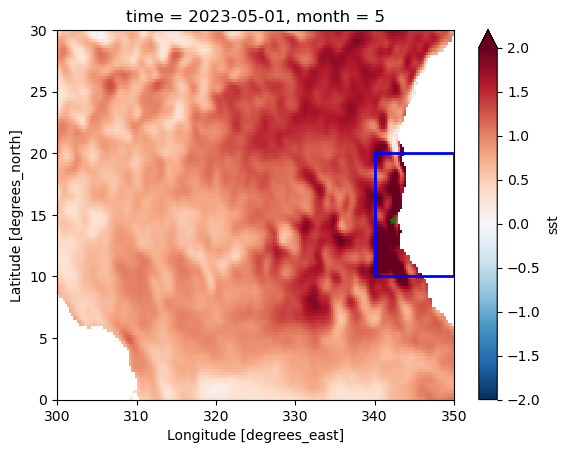

In [78]:
t = "2023-05-01"; #date

# Add a rectangle on top
# Arguments: (x, y), width, height
rect = patches.Rectangle((lon_min_sm, lat_min_sm), 10, 10, linewidth=2, edgecolor='blue', facecolor='none')

fig, ax = plt.subplots()
dc_anom.sel(time = t).plot(cmap = colormap, vmin = -2, vmax = 2)
ax.add_patch(rect)

ax.plot(deployment0101_lon, deployment0101_lat, marker='*', color='g', markersize=5)

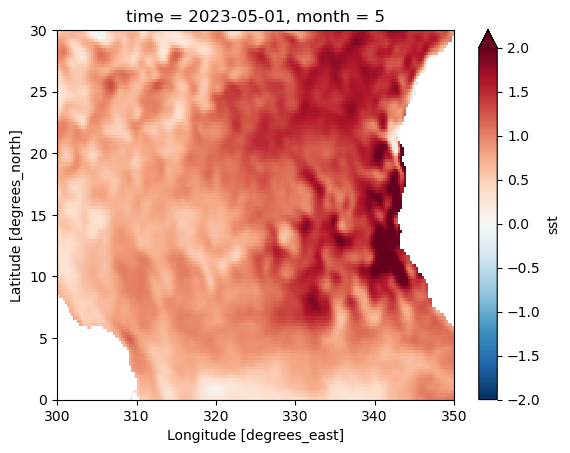

In [47]:
t = "2023-05-01"; #date
dc_anom.sel(time = t).plot(cmap = colormap, vmin = -2, vmax = 2)

# Produce monthly anomalies by a different method, then compare the two of them
## climatology2 is the second climatology

In [80]:
#dc.groupby?

#print(dc.time.dt)
#print(dc.time.dt.month)

#gb = ds.sst.groupby(ds.time.dt.month)
#gb

gb = dc.groupby('time.month')
gb
type(gb)

#there are only 2 things inside this particular groupby, so you can choose any name you want
for group_name, group_da in gb:
    # stop iterating after the first loop
    break 
print(group_name)
group_da

#gb.map(np.mean)
climatology2 = gb.mean(dim='time')
climatology2.shape

1


(12, 80, 80)

In [81]:
climatology2

<xarray.DataArray 'sst' (month: 12, latitude: 80, longitude: 80)> Size: 307kB
array([[[27.401087, 27.38976 , 27.37525 , ..., 27.218723, 27.245491,
         27.272175],
        [27.428806, 27.412708, 27.400051, ..., 27.388477, 27.415108,
         27.439978],
        [27.464703, 27.447989, 27.436024, ..., 27.549099, 27.56787 ,
         27.589865],
        ...,
        [23.285814, 23.24093 , 23.194351, ...,       nan,       nan,
               nan],
        [23.252151, 23.207748, 23.166632, ...,       nan,       nan,
               nan],
        [23.218649, 23.17366 , 23.136662, ...,       nan,       nan,
               nan]],

       [[27.610943, 27.623043, 27.640762, ..., 27.746778, 27.771595,
         27.78992 ],
        [27.619318, 27.63053 , 27.648956, ..., 27.878567, 27.904488,
         27.923405],
        [27.629192, 27.638575, 27.654356, ..., 28.009136, 28.033972,
         28.05151 ],
...
        [25.676697, 25.649658, 25.631031, ...,       nan,       nan,
               nan],
        [25.633217, 25.60921 , 25.58982 , ...,       nan,       nan,
               nan],
        [25.5961  , 25.573294, 25.549969, ...,       nan,       nan,
               nan]],

       [[27.11531 , 27.102047, 27.08318 , ..., 26.570269, 26.599962,
         26.633038],
        [27.175041, 27.162077, 27.146069, ..., 26.793945, 26.823023,
         26.856714],
        [27.24811 , 27.238049, 27.227125, ..., 26.985483, 27.014238,
         27.05102 ],
        ...,
        [24.538124, 24.511763, 24.477629, ...,       nan,       nan,
               nan],
        [24.499317, 24.471066, 24.436346, ...,       nan,       nan,
               nan],
        [24.464613, 24.4342  , 24.396984, ...,       nan,       nan,
               nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 320B 0.125 0.375 0.625 ... 19.38 19.62 19.88
  * longitude  (longitude) float32 320B 330.1 330.4 330.6 ... 349.4 349.6 349.9
  * month      (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/13)
    actual_range:     [-1.8  32.14]
    colorBarMaximum:  32.0
    colorBarMinimum:  0.0
    ioos_category:    Temperature
    level_desc:       Surface
    long_name:        Monthly Mean of Sea Surface Temperature
    ...               ...
    precision:        2.0
    standard_name:    sea_surface_temperature
    statistic:        Monthly Mean
    units:            degree_C
    valid_range:      [-3. 45.]
    var_desc:         Sea Surface Temperature

# Plot two climatologies next to one another

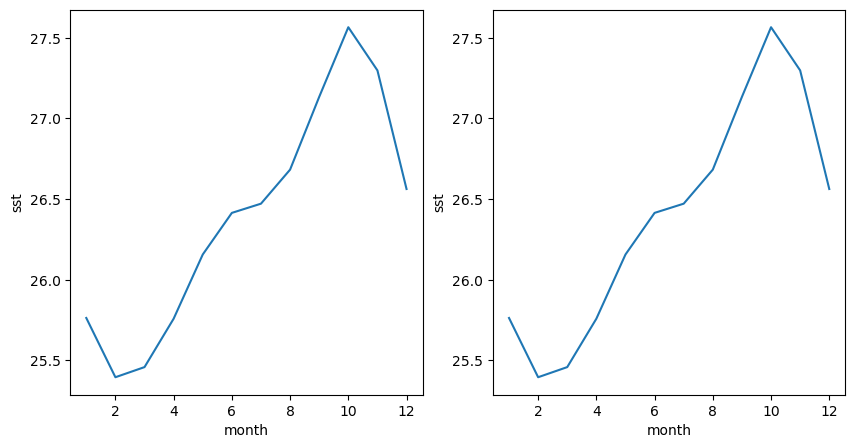

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
climatology.mean(dim = ['latitude','longitude']).plot(ax = axes[0])
climatology2.mean(dim=['latitude', 'longitude']).plot(ax=axes[1])

# Plot a single anomaly map from each method, to compare

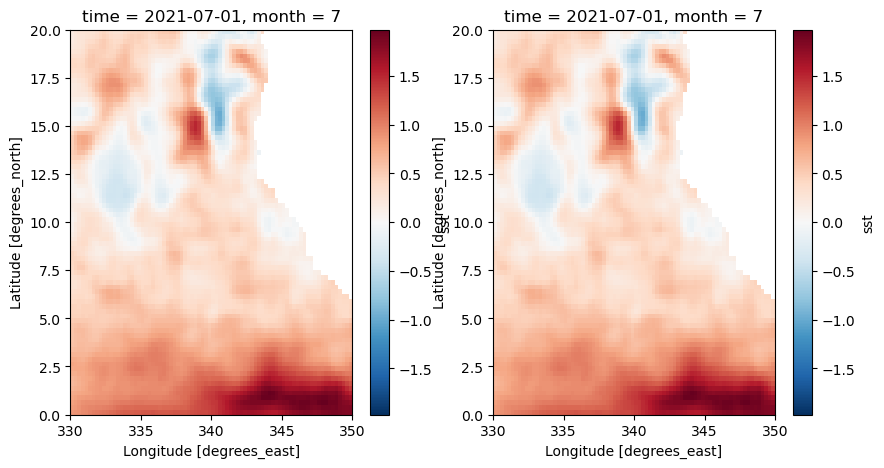

In [86]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
t = "2021-07-01"; m = 7; #date and month
dc_anom.sel(time = t).plot(ax = axes[0])
(dc.sel(time = t) - climatology2.sel(month = m)).plot(ax=axes[1])